# Gene type prediction with Transformers

Data collected from [Kaggle](https://www.kaggle.com/datasets/harshvardhan21/dna-sequence-prediction?resource=download&select=validation.csv) referes to nuocletide sequences and gene type encoded within them.

In [4]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [5]:
from eda import SequenceEDA
from preprocess import SequencePreprocess
from model import TransformerClassifier, plot_confusion_matrix

In [6]:
#load the datasets
train_df = pd.read_csv('train.csv', encoding='ascii')
val_df = pd.read_csv('validation.csv', encoding='ascii')
test_df = pd.read_csv('test.csv', encoding='ascii')

#dump on screen the shapes of the datasets
print('Training data shape:', train_df.shape)
print('Validation data shape:', val_df.shape)
print('Test data shape:', test_df.shape)

Training data shape: (22593, 7)
Validation data shape: (4577, 7)
Test data shape: (8326, 7)


In [7]:
#dump first five rwas on screen
train_df.head()

,Unnamed: 0,NCBIGeneID,Symbol,Description,GeneType,GeneGroupMethod,NucleotideSequence
0,0,106481178,RNU4-21P,"RNA, U4 small nuclear 21, pseudogene",PSEUDO,NCBI Ortholog,<AGCTTAGCACAGTGGCAGTATCATAGGCAGTGAGGTTTATCCGAG...
1,1,123477792,LOC123477792,Sharpr-MPRA regulatory region 12926,BIOLOGICAL_REGION,NCBI Ortholog,<CTGGAGCGGCCACGATGTGAACTGTCACCGGCCACTGCTGCTCCG...
2,2,113174975,LOC113174975,Sharpr-MPRA regulatory region 7591,BIOLOGICAL_REGION,NCBI Ortholog,<TTCCCAATTTTTCCTCTGCTTTTTAATTTTCTAGTTTCCTTTTTC...
3,3,116216107,LOC116216107,CRISPRi-validated cis-regulatory element chr10...,BIOLOGICAL_REGION,NCBI Ortholog,<CGCCCAGGCTGGAGTGCAGTGGCGCCATCTCGGCTCACTGCAGGC...
4,4,28502,IGHD2-21,immunoglobulin heavy diversity 2-21,OTHER,NCBI Ortholog,<AGCATATTGTGGTGGTGACTGCTATTCC>


In [8]:
#remove < and >

train_df['NucleotideSequence'] = train_df['NucleotideSequence'].str.strip('<>')
val_df['NucleotideSequence'] = val_df['NucleotideSequence'].str.strip('<>')
test_df['NucleotideSequence'] = test_df['NucleotideSequence'].str.strip('<>')

## EDA

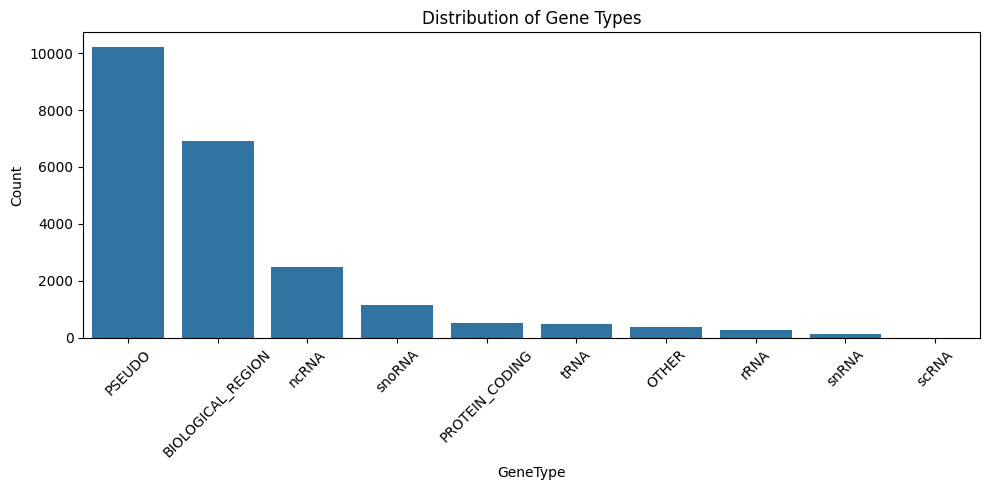

In [9]:
#define seq eda object
seq_eda = SequenceEDA(train_df, 'NucleotideSequence', 'GeneType')

#plot sequence length distribution
seq_eda.plot_gene_type_distribution()

From the plot, it is immediately apparent that the dataset is highly imbalanced. The distribution of samples across the different classes is extremely uneven, with the largest class containing nearly 10,000 samples, while the smallest class has only a single sample. This pronounced disparity highlights a significant challenge for any classification model, as the model may become biased toward the majority class and struggle to correctly predict the minority classes.

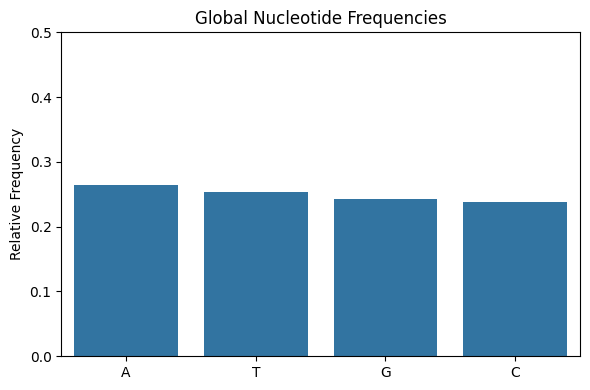

In [10]:
seq_eda.plot_nucleotide_frequencies()

The overall distribution of nucleotide frequencies appears relatively flat, with no individual nucleotide showing a dominant prevalence across the dataset. This uniformity suggests an absence of strong compositional biases within the sequences and provides limited biological insight into the underlying structure or function of the nucleotide regions. In particular, the lack of distinctive patterns or enrichment in specific bases implies that the sequences, when considered globally, may not reflect highly specialized motifs or conserved regions typically associated with particular biological roles.

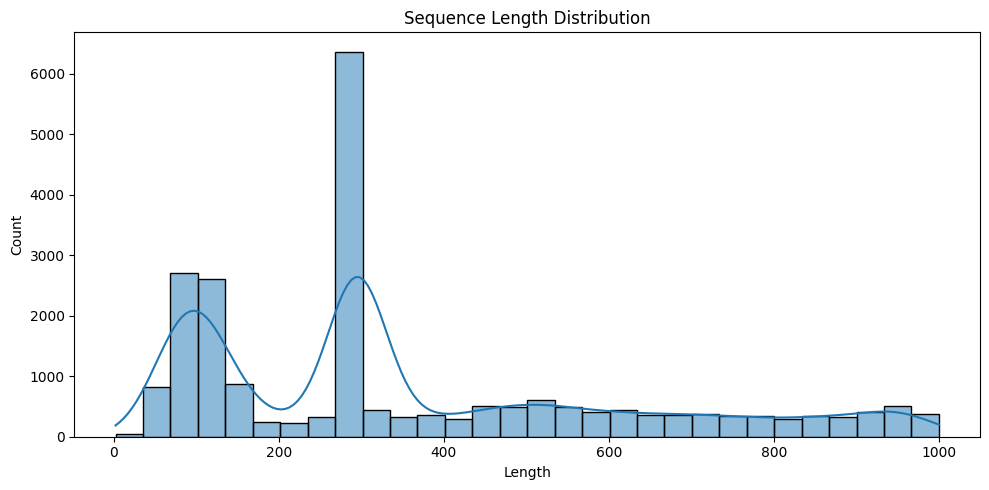

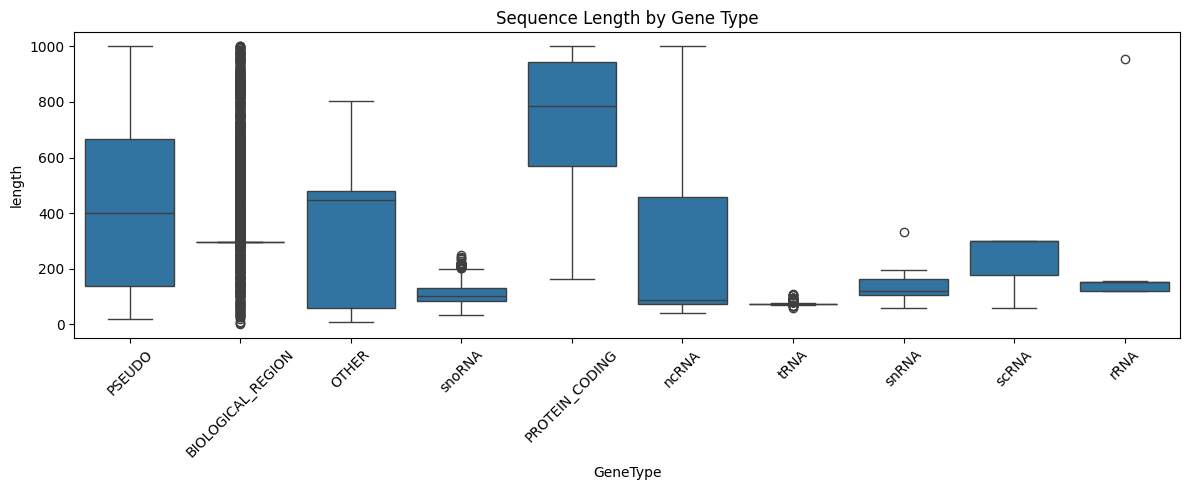

In [11]:
seq_eda.plot_sequence_length_distribution()

The distribution of nucleotide sequence lengths is heterogeneous, with a prominent peak around 284 nucleotides. Most gene types exhibit relatively well-defined and consistent sequence lengths, suggesting a degree of structural uniformity within those categories. However, the gene type labeled as biological region shows considerable variability, characterized by a wide range of lengths and a significant number of outliers. This indicates that biological region may encompass a more diverse set of genomic elements, possibly including regulatory regions, enhancers, or non-coding sequences with less constrained structural requirements.

## Prediction

In [12]:
#build object for preprocessing
train_prepro = SequencePreprocess(train_df)
valid_prepro = SequencePreprocess(val_df)
test_prepro = SequencePreprocess(test_df)

### Tokenization

In [13]:
#tokenize the sequences with k-mers
train_prepro.tokenize('NucleotideSequence',k=6)
valid_prepro.tokenize('NucleotideSequence',k=6)
test_prepro.tokenize('NucleotideSequence',k=6)

### Encoding

In [14]:
#encoding the sequences
train_prepro.encode()
valid_prepro.encode()
test_prepro.encode()

### Label encoding

In [15]:
#initialize label encoder
le = LabelEncoder()

#fit and transform labels into numeric ids
le.fit(train_df['GeneType'])
y_train = le.transform(train_df['GeneType'])
y_val = le.transform(val_df['GeneType'])
y_test = le.transform(test_df['GeneType'])

### Padding

In [16]:
#maximum length of dna sequence
max_len = max(len(sublist) for sublist in train_prepro.tokens)

train_prepro.pad_sequences(max_len)
valid_prepro.pad_sequences(max_len)
test_prepro.pad_sequences(max_len)
print('Max sequence length:', max_len)

Max sequence length: 995


### Get training, validation and test set

In [17]:
X_train = train_prepro.padded
X_val = valid_prepro.padded
X_test = test_prepro.padded
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)

X_train shape: (22593, 995)
X_val shape: (4577, 995)
X_test shape: (8326, 995)


### Transformer model

In [18]:
transformer = TransformerClassifier(
    vocab_size=4097,  #k-mer 6 + 1 for padding
    max_len=max_len,
    num_classes=len(le.classes_),)

model = transformer.build()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'sinusoidal_positional_encoding' (of type SinusoidalPositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 995)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 995, 128)  │    524,416 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sinusoidal_positio… │ (None, 995, 128)  │          0 │ embedding[0][0]   │
│ (SinusoidalPositio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 995, 128)  │    263,808 │ sinusoidal_posit… │
│ (MultiHeadAttentio… │                   │            │ sinusoidal_posit… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 995, 128)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 995, 128)  │          0 │ sinusoidal_posit… │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 995, 128)  │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 995, 256)  │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 995, 128)  │     32,896 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 995, 128)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 995, 128)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 995, 128)  │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 10)        │      1,290 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 855,946 (3.27 MB)

 Trainable params: 855,946 (3.27 MB)

 Non-trainable params: 0 (0.00 B)

### Fit model

In [19]:
#early stopping
early_stop = EarlyStopping(
    monitor='val_loss',        #metric to monitor
    patience=5,                #stop if no improvement after 5 epochs
    restore_best_weights=True  #restore model weights from best epoch
)

#learning rate decay
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',        #metric to monitor
    factor=0.5,                #reduce lr by factor
    patience=3,                #wait 3 epochs before reducing
    min_lr=1e-6                #minimum learning rate
)

#fit model
model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_val, y_val),  #provide validation set explicitly
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 101s 124ms/step - accuracy: 0.6389 - loss: 1.0471 - val_accuracy: 0.8106 - val_loss: 0.5811 - learning_rate: 0.0010
Epoch 2/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 83s 117ms/step - accuracy: 0.8185 - loss: 0.5642 - val_accuracy: 0.8007 - val_loss: 0.5620 - learning_rate: 0.0010
Epoch 3/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 83s 117ms/step - accuracy: 0.8389 - loss: 0.4844 - val_accuracy: 0.8822 - val_loss: 0.3591 - learning_rate: 0.0010
Epoch 4/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 83s 117ms/step - accuracy: 0.8784 - loss: 0.3633 - val_accuracy: 0.8964 - val_loss: 0.3172 - learning_rate: 0.0010
Epoch 5/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 83s 117ms/step - accuracy: 0.8987 - loss: 0.2985 - val_accuracy: 0.9126 - val_loss: 0.2638 - learning_rate: 0.0010
Epoch 6/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 83s 117ms/step - accuracy: 0.9194 - loss: 0.2401 - val_accuracy: 0.9456 - val_loss: 0.1719 - learning_rate: 0.0010
Epoch 7/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 83s 117ms/step - accur

### Evaluate

In [20]:
_,accuracy = model.evaluate(X_train,y_train)
print('Train accuracy:',accuracy)
_,accuracy = model.evaluate(X_test,y_test)
print('Test accuracy:',accuracy)

707/707 ━━━━━━━━━━━━━━━━━━━━ 28s 39ms/step - accuracy: 0.9994 - loss: 0.0019
Train accuracy: 0.9992032647132874
261/261 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9639 - loss: 0.3745
Test accuracy: 0.9783809781074524


The test accuracy achieved by the model is 0.97, which is relatively high considering the number of classes (10) and the significant imbalance present in the dataset. Taking into account that some classes have only a few samples while others contain thousands, reaching this level of accuracy indicates that the transformer model is handling the data distribution effectively. It suggests that the model is able to capture meaningful patterns across both the majority and minority classes, despite the challenges posed by the uneven class frequencies. Overall, these results provide encouraging evidence that the transformer architecture is capable of learning robust representations even from datasets with highly skewed class distributions.

Furthermore, considering that the training accuracy reaches 0.99, there is minimal indication of overfitting in the model. This stability in performance is likely supported by the implementation of early stopping, which monitors the validation loss and halts training when no further improvement is observed. As a result, the model maintains a balanced generalization capability, avoiding excessive memorization of the training data while still capturing the relevant patterns necessary for accurate predictions.

261/261 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step


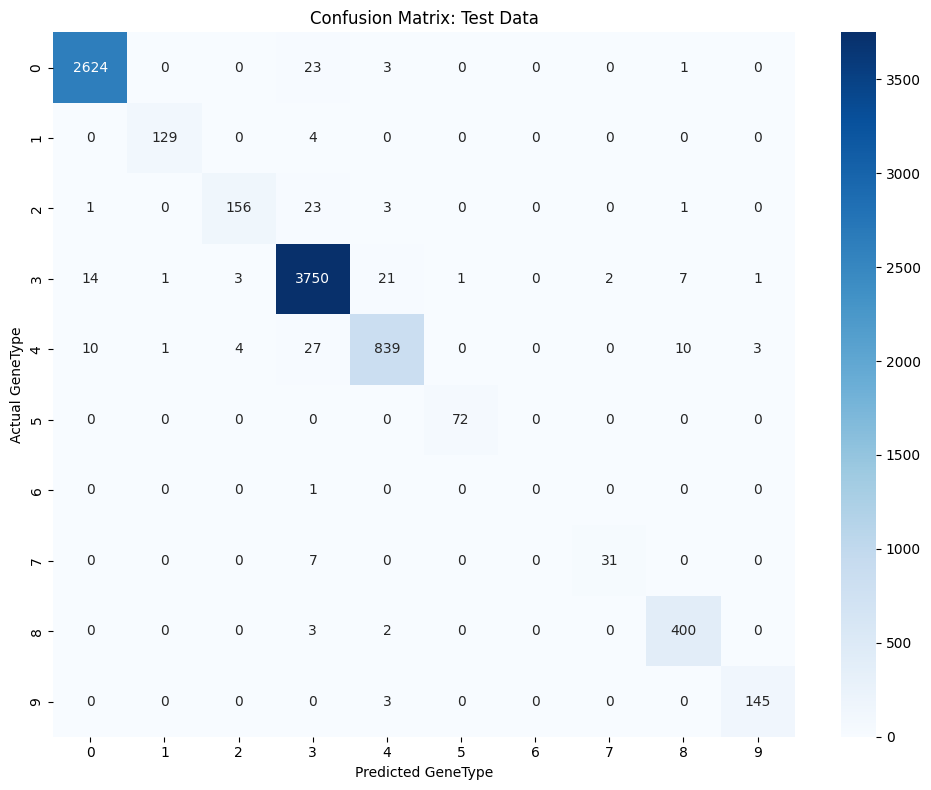

In [21]:
#plot confusion matrix
plot_confusion_matrix(model,X_test,y_test)

With the exception of the least represented classes (6), all other classes appear to be generally well classified, as evidenced by the confusion matrix. The model demonstrates strong discriminative ability for the majority of classes, with high true positive rates and minimal confusion across most categories. The limited performance on classes 6 and 7 is likely attributable to their underrepresentation in the training set, which reduces the model’s ability to learn robust patterns for these categories.